# ARIMA Models Predictions for Kalbe Nutritional Product

# Loading Library and Datasets

In [1]:
# importing necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df_customer = pd.read_csv('Case Study - Customer.csv', sep= ';')
df_product = pd.read_csv('Case Study - Product.csv', sep= ';')
df_store = pd.read_csv('Case Study - Store.csv', sep= ';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', sep= ';')

In [3]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [5]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [6]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


In [7]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [8]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes


In [9]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [10]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


Data Preparation

In [13]:
# Merge all table into one

merged_df = pd.merge(df_transaction, df_product,on='ProductID', suffixes = ('_customers', '_product'))
merged_df = pd.merge(merged_df, df_store, on='StoreID')
final_merged_df = pd.merge(merged_df, df_customer, on='CustomerID')
final_merged_df= final_merged_df.drop(['Price_customers'], axis = 1)
final_merged_df.sample(5)

,TransactionID,CustomerID,Date,ProductID,Qty,TotalAmount,StoreID,Product Name,Price_product,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
2978,TR17660,209,29/08/2022,P6,3,54000,12,Cashew,18000,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",47,0,Single,"2,55"
4702,TR76051,138,03/06/2022,P10,3,45000,4,Cheese Stick,15000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",37,1,Married,"8,96"
1880,TR94759,215,22/11/2022,P6,3,54000,10,Cashew,18000,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513",25,0,Single,"5,54"
3954,TR58438,417,10/12/2022,P10,3,45000,2,Cheese Stick,15000,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",47,1,Married,"12,75"
2305,TR21056,62,15/01/2022,P8,3,48000,5,Oat,16000,Bonafid,Gita,General Trade,"-7,250445","112,768845",51,1,Married,"13,62"


In [14]:
# rename all column to lowercase and drop irrelevant column in table
for column in final_merged_df.columns:
    final_merged_df.rename(columns ={column: column.lower()}, inplace = True)
final_merged_df.rename(columns = {'marital status': 'marital_status'}, inplace = True)
final_merged_df.rename(columns = {'product name': 'product_name'}, inplace = True)
final_merged_df.sample(5)

# drop irrelevant column and change data type
df = final_merged_df.drop(['latitude', 'longitude'], axis=1)
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y', infer_datetime_format=True)
df.sample(5)

,transactionid,customerid,date,productid,qty,totalamount,storeid,product_name,price_product,storename,groupstore,type,age,gender,marital_status,income
341,TR1152,149,2022-01-27,P3,6,45000,9,Crackers,7500,Lingga,Lingga,Modern Trade,61,1,Married,"3,96"
4855,TR9249,147,2022-08-23,P5,5,21000,11,Thai Tea,4200,Sinar Harapan,Prestasi,General Trade,59,1,Married,"8,02"
4707,TR29483,138,2022-11-18,P8,1,16000,2,Oat,16000,Prima Kelapa Dua,Prima,Modern Trade,37,1,Married,"8,96"
4130,TR85167,90,2022-08-10,P2,6,19200,11,Ginger Candy,3200,Sinar Harapan,Prestasi,General Trade,21,1,Single,0
1147,TR44584,238,2022-03-26,P8,3,48000,4,Oat,16000,Gita Ginara,Gita,General Trade,26,0,Single,"6,61"


In [15]:
# check dataframe info and shape
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transactionid   5020 non-null   object        
 1   customerid      5020 non-null   int64         
 2   date            5020 non-null   datetime64[ns]
 3   productid       5020 non-null   object        
 4   qty             5020 non-null   int64         
 5   totalamount     5020 non-null   int64         
 6   storeid         5020 non-null   int64         
 7   product_name    5020 non-null   object        
 8   price_product   5020 non-null   int64         
 9   storename       5020 non-null   object        
 10  groupstore      5020 non-null   object        
 11  type            5020 non-null   object        
 12  age             5020 non-null   int64         
 13  gender          5020 non-null   int64         
 14  marital_status  4976 non-null   object        
 15  inco

(5020, 16)

In [16]:
# checking null values
df.isna().sum()

transactionid      0
customerid         0
date               0
productid          0
qty                0
totalamount        0
storeid            0
product_name       0
price_product      0
storename          0
groupstore         0
type               0
age                0
gender             0
marital_status    44
income             0
dtype: int64

In [17]:
# fill null values with mode method
mode_marital_status = df['marital_status'].mode()[0]
df['marital_status'].fillna(mode_marital_status, inplace = True)
df.isna().sum()

transactionid     0
customerid        0
date              0
productid         0
qty               0
totalamount       0
storeid           0
product_name      0
price_product     0
storename         0
groupstore        0
type              0
age               0
gender            0
marital_status    0
income            0
dtype: int64

# Forecasting

In [18]:
# make a new dataframe consisting of forecast dataframe
df_forecast = df[['date','qty']]
df_forecast = df_forecast.groupby('date')[['qty']].sum()
df_forecast.head(5)

,qty
date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30


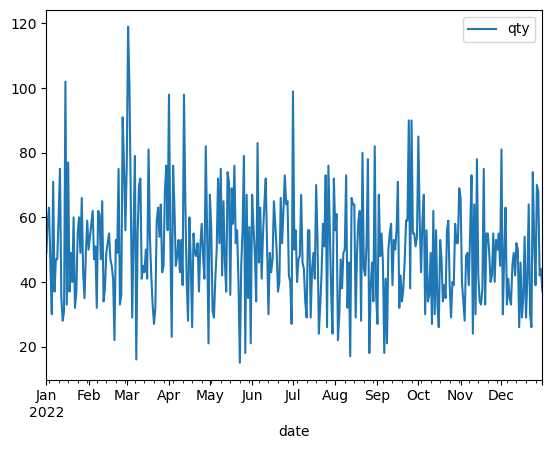

In [19]:
# Plot the quantity based on date
df_forecast.plot()
plt.show()

Text(0.5, 1.0, 'Raw Data')

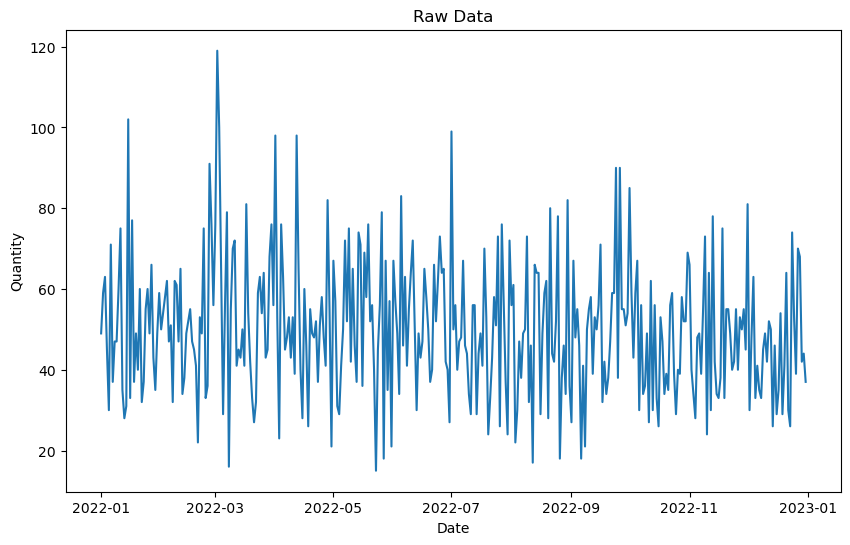

In [20]:
# Plot the raw data
plt.figure(figsize=(10, 6))
plt.plot(df_forecast.index, df_forecast['qty'])
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Raw Data')

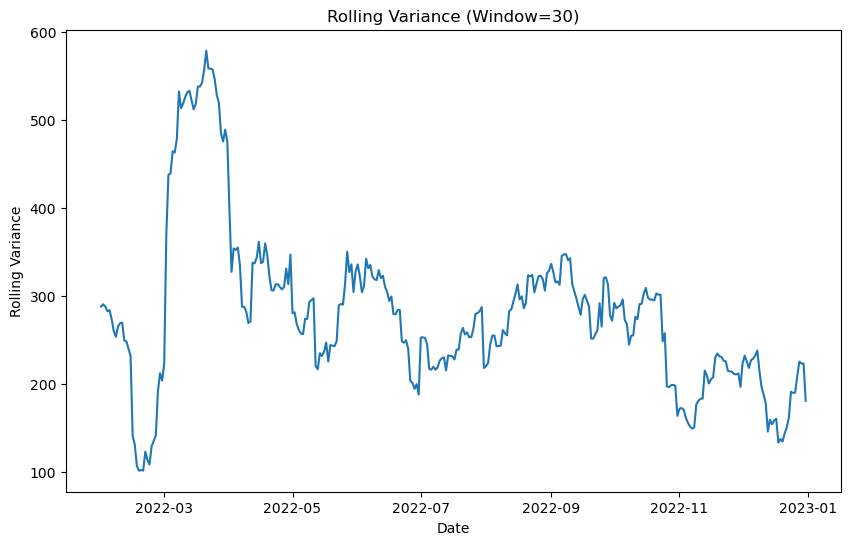

In [21]:
# Compute rolling variance and plot
window = 30  # Adjust the window size as needed
rolling_var = df_forecast['qty'].rolling(window=window).var()
plt.figure(figsize=(10, 6))
plt.plot(df_forecast.index, rolling_var)
plt.xlabel('Date')
plt.ylabel('Rolling Variance')
plt.title(f'Rolling Variance (Window={window})')

plt.show()

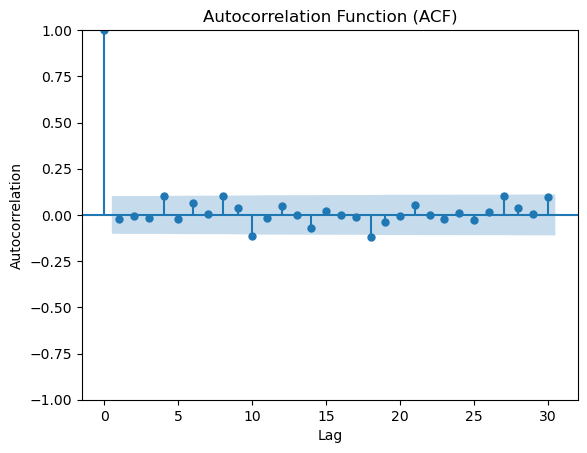

In [22]:
# Plot ACF using default method
plot_acf(df_forecast, lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

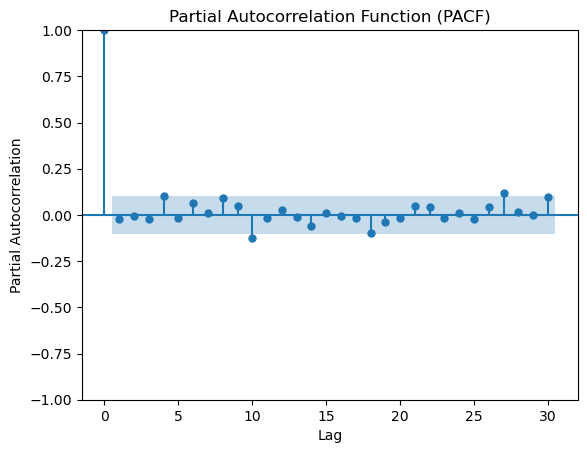

In [23]:
# Plot PACF using ywm method
plot_pacf(df_forecast, lags=30,  method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [24]:
# Check if the data stationary or not
df_test = adfuller(df_forecast)
adf = df_test[0]
pval = df_test[1]

print('ADF Statistics : ', adf)
print('P Value : ', pval)
for key, value in df_test[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistics :  -19.448086319449075
P Value :  0.0
Critical Values:
   1%, -3.4484434475193777
Critical Values:
   5%, -2.869513170510808
Critical Values:
   10%, -2.571017574266393


In [25]:
df_forecast.shape[0]

365

# Arima Model Predictions

In [26]:
# Split the data into training and testing sets
train_df = df_forecast.iloc[:-31]
test_df = df_forecast.iloc[-31:]

# Check the shapes of the train and test sets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (334, 1)
Testing set shape: (31, 1)


In [28]:
# check which ARIMA models best suit using auto ARIMA
auto_arima_model = pm.auto_arima(train_df, seasonal=False, stepwise=False, suppress_warnings=True, trace = True)
auto_arima_model.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3067.753, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2969.103, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2939.868, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2897.396, Time=0.19 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1432.364
Date:                Sun, 30 Jul 2023   AIC                           2878.729
Time:                        14:05:20   BIC                           2905.386
Sample:                    01-01-2022   HQIC                          2889.358
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0361      1.012     -0.036      0.972      -2.020       1.948
ar.L1         -0.8641      0.056    -15.420      0.000      -0.974      -0.754
ar.L2         -0.7198      0.068    -10.629      0.000      -0.852      -0.587
ar.L3         -0.6062      0.064     -9.450      0.000      -0.732      -0.480
ar.L4         -0.3322      0.059     -5.629      0.000      -0.448      -0.217
ar.L5         -0.1927      0.053     -3.668      0.000      -0.296      -0.090
sigma2       317.7588     24.003     13.238      0.000     270.714     364.804
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 4.88
Prob(Q):                              0.59   Prob(JB):                         0.09
Heteroskedasticity (H):               0.76   Skew:                             0.22
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# fit the ARIMA model using best model from auto arima
best_order = auto_arima_model.order
model = ARIMA (train_df, order=best_order)
arima_model = model.fit()
print(arima_model.summary())

C:\Users\Rey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Rey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Rey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  334
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1432.365
Date:                Sun, 30 Jul 2023   AIC                           2876.730
Time:                        14:11:32   BIC                           2899.579
Sample:                    01-01-2022   HQIC                          2885.841
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8641      0.055    -15.623      0.000      -0.972      -0.756
ar.L2         -0.7197      0.068    -10.630      0.000      -0.852      -0.587
ar.L3         -0.6062      0.064     -9.476      0.0

In [30]:
# Make a new dataframe for forecast
forecast_period = test_df.shape[0]
forecast = arima_model.forecast(steps=forecast_period)
forecast_index = pd.date_range(start=test_df.index[-1], periods=forecast_period)
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['qty'])

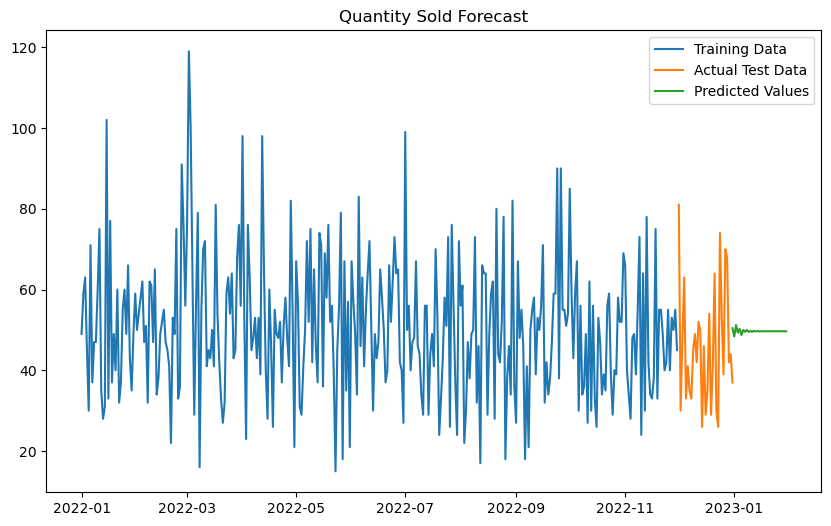

In [31]:
# Plot and Visualize Predicted Values for Quantity Sold
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['qty'], label='Training Data')
plt.plot(test_df.index, test_df['qty'], label='Actual Test Data')
plt.plot(forecast_df.index, forecast, label='Predicted Values')
plt.title('Quantity Sold Forecast')
plt.legend()
plt.show()

In [32]:
# Evaluate the model
mae = mean_absolute_error(test_df['qty'], forecast)
mape = mean_absolute_percentage_error(test_df['qty'], forecast) * 100
rmse = mean_squared_error(test_df['qty'], forecast, squared=False)

print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse}")

MAE: 12.755126785236142
MAPE: 32.48%
RMSE: 15.053042794778822


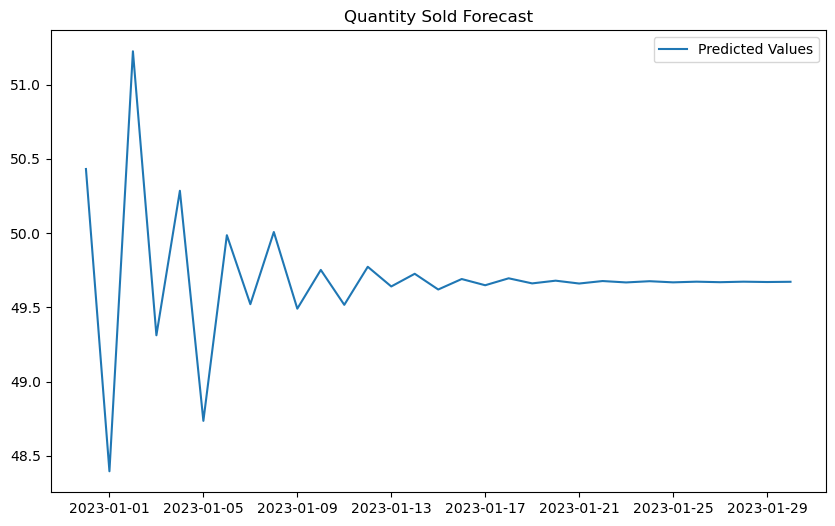

In [33]:
# Plot and Visualize Predicted Values for Quantity Sold
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast, label='Predicted Values')
plt.title('Quantity Sold Forecast')
plt.legend()
plt.show()

Conclusion : Grafik tersebut menggambarkan nilai prediksi Quantity Sold Forecast selama 1 bulan. Ini memberikan representasi visual dari jumlah penjualan yang diharapkan untuk 30 hari mendatang berdasarkan model peramalan kami. Selain itu, kami telah menghitung rata-rata perkiraan jumlah penjualan bulanan, dan hasilnya adalah 50,0.

In [34]:
# Check Mean Quantity Sold per Day
mean_qty_sold = forecast.mean().round()
print(f"Mean Quantity Sold Per day: {mean_qty_sold}")

Mean Quantity Sold Per day: 50.0


# Forecast Quantity Each Product

In [35]:
# forecasting quantity of each product for 1 month
df_prod_forecast = df[['qty', 'date', 'product_name']]

# Forecast for next 30 days for each product
product_list = df_prod_forecast['product_name'].unique()

# Create a DataFrame to store the forecasts
forecast_df = pd.DataFrame({'date': pd.date_range(start='2023-01-01', end='2023-01-30')})

# Function to fit ARIMA model and make forecasts
def fit_arima_forecast(df_forecast):
    model = ARIMA(df_forecast['qty'], order=best_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=30)
    return forecast

# Group data by 'product_name', and then apply the forecasting function for each group
for i, group in df_prod_forecast.groupby('product_name'):
    df_forecast = group[['date', 'qty']]
    df_forecast = df_forecast.groupby('date')[['qty']].sum()

    # Set the index to fill missing dates
    df_forecast = df_forecast.reindex(pd.date_range(start='2022-01-01', end='2022-12-31'), fill_value=0)

    # Fit ARIMA model and make forecasts
    forecast1 = fit_arima_forecast(df_forecast)

    # Add forecasts to the main DataFrame
    forecast_df[i] = forecast1.values

forecast_df = forecast_df.set_index('date')
forecast_df.head()

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
date,,,,,,,,,,
2023-01-01,1.820271,6.701247,5.023622,6.708973,6.106235,7.841138,2.643269,3.624533,4.672604,3.830957
2023-01-02,2.050780,7.967038,6.096409,6.570339,5.634547,8.999709,3.249200,1.761774,4.792271,4.280938
2023-01-03,1.838230,6.139172,5.936069,6.519189,5.230499,7.374542,2.876848,2.535615,3.967512,4.739068
2023-01-04,1.770446,6.653011,3.849957,6.750441,5.211875,6.900365,2.967520,3.141005,4.957475,4.547295
2023-01-05,1.244804,6.401178,5.129626,7.808847,4.899641,6.950302,2.926173,3.211266,4.874770,4.088417


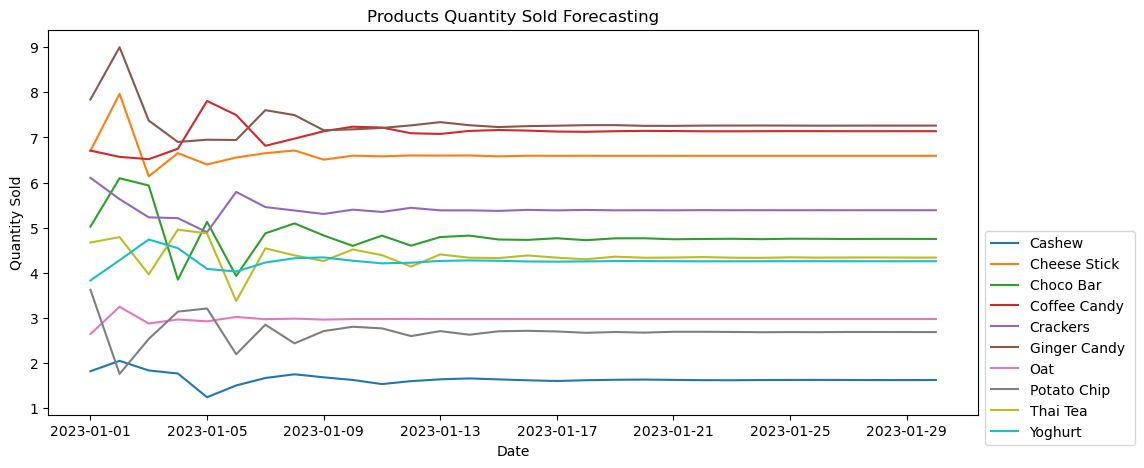

In [36]:
# Plot forecasting
plt.figure(figsize=(12, 5))
for i in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[i], label=i)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.title('Products Quantity Sold Forecasting')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

In [37]:
# Check mean per product sold daily
mean_qty_per_product = df.groupby('product_name')['qty'].mean().round()
mean_qty_per_product_table = pd.DataFrame(mean_qty_per_product).reset_index()
mean_qty_per_product_table.columns = ['Product Name', 'Mean Quantity Sold Daily']

# Convert the DataFrame to a nicely formatted table
table = tabulate(mean_qty_per_product_table, headers='keys', tablefmt='fancy_grid', showindex=False)

# Print the table
print(table)

╒════════════════╤════════════════════════════╕
│ Product Name   │   Mean Quantity Sold Daily │
╞════════════════╪════════════════════════════╡
│ Cashew         │                          2 │
├────────────────┼────────────────────────────┤
│ Cheese Stick   │                          3 │
├────────────────┼────────────────────────────┤
│ Choco Bar      │                          6 │
├────────────────┼────────────────────────────┤
│ Coffee Candy   │                          4 │
├────────────────┼────────────────────────────┤
│ Crackers       │                          4 │
├────────────────┼────────────────────────────┤
│ Ginger Candy   │                          5 │
├────────────────┼────────────────────────────┤
│ Oat            │                          2 │
├────────────────┼────────────────────────────┤
│ Potato Chip    │                          3 │
├────────────────┼────────────────────────────┤
│ Thai Tea       │                          4 │
├────────────────┼──────────────────────

Conclusion : Berdasarkan grafik dan tabel yang disediakan, kita dapat mengamati nilai prediksi Prakiraan Kuantitas Terjual untuk Setiap Produk yang Terjual Setiap Hari dalam waktu 1 bulan, dengan menggunakan rata-rata data penjualan historis. Grafik tersebut secara visual merepresentasikan jumlah yang diperkirakan untuk setiap produk selama 30 hari ke depan, sedangkan tabel menyajikan jumlah rata-rata harian yang terjual untuk setiap produk.